In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
%matplotlib widget
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy import stats
from scipy.stats import chi2 
from scipy.stats.distributions import  t
from scipy import signal
from scipy.signal import welch 
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.integrate import quad_vec
from scipy.special import gamma

#Personal packages
import vector_tools as vt

In [2]:
#Import data
ADV1data = xr.open_dataset('ADV/adv1_final.nc')
ADV2data = xr.open_dataset('ADV/adv2_final.nc')
TEMPdata = xr.open_dataset('Temperature/temp_final.nc')

# Using ADV Spectral data to estimate wave parameters
# and turbulent dissipation

In [4]:
adv1Spectra = vt.ADV_spectraDS(ADV1data, TEMPdata, selBurstNumbers=None, segLength=60, window='hann',pNoisefloorFreq=.4, vNoisefloorFreq=3.5, wtNoisefloorFactor=12,wtPeakwaveFactor=1.1, wtSlope = -4)
eps1 = vt.EpsCalc_from_SpectraDS(adv1Spectra, TEMPdata, minimumGap=1, noiseFrequency = None)
#adv2Spectra = ADV_spectraDS(ADV2data, TEMPdata, selBurstNumbers=None, segLength=60, window='hann',pNoisefloorFreq=.4, vNoisefloorFreq=3.5, wtNoisefloorFactor=12,wtPeakwaveFactor=1.1, wtSlope = -4)
#eps2 = vt.EpsCalc_from_SpectraDS(eps2_final, TEMPdata, minimumGap=1, noiseFrequency = None)

Burst #0 of 216
Burst #1 of 216
Burst #2 of 216
Burst #3 of 216
Burst #4 of 216
Burst #5 of 216
Burst #6 of 216
Burst #7 of 216
Burst #8 of 216
Burst #9 of 216
Burst #10 of 216
Burst #11 of 216
Burst #12 of 216
Burst #13 of 216
Burst #14 of 216
Burst #15 of 216
Burst #16 of 216
Burst #17 of 216
Burst #18 of 216
Burst #19 of 216
Burst #20 of 216
Burst #21 of 216
Burst #22 of 216
Burst #23 of 216
Burst #24 of 216
Burst #25 of 216
Burst #26 of 216
Burst #27 of 216
Burst #28 of 216
Burst #29 of 216
Burst #30 of 216
Burst #31 of 216
Burst #32 of 216
Burst #33 of 216
Burst #34 of 216
Burst #35 of 216
Burst #36 of 216
Burst #37 of 216
Burst #38 of 216
Burst #39 of 216
Burst #40 of 216
Burst #41 of 216
Burst #42 of 216
Burst #43 of 216
Burst #44 of 216
Burst #45 of 216
Burst #46 of 216
Burst #47 of 216
Burst #48 of 216
Burst #49 of 216
Burst #50 of 216
Burst #51 of 216
Burst #52 of 216
Burst #53 of 216
Burst #54 of 216
Burst #55 of 216
Burst #56 of 216
Burst #57 of 216
Burst #58 of 216
Burst #

In [5]:
eps1.to_netcdf('Dissipation/eps1_final.nc')
#eps2.to_netcdf('Dissipation/eps2_final2.nc')

In [2]:
eps1_orig = xr.open_dataset('Dissipation/eps1.nc')
eps1_final = xr.open_dataset('Dissipation/eps1_final.nc')

eps2_orig = xr.open_dataset('Dissipation/eps2.nc')
eps2_final = xr.open_dataset('Dissipation/eps2_final.nc')

In [19]:
orig = adv2_orig.Up.where(adv2_orig.BurstNum.isin(13)).dropna(dim='time',how='all')
final = adv2_final.Up.where(adv2_final.BurstNum.isin(13)).dropna(dim='time',how='all')
fOrig, sOrig = welch(orig, fs=32, nperseg = (60*32),window='hann', detrend='linear')
fFinal, sFinal = welch(final, fs=32,nperseg=(60*32),window='hann',detrend='linear')

# Plotting wave parameters and turbulent dissipation

In [7]:
adv1_final = xr.open_dataset('ADV/adv1_final.nc')
adv2_final = xr.open_dataset('ADV/adv2_final.nc')

In [21]:
goodEps = eps1.eps.where(eps1.UpOrigRatio < .4)#.dropna(dim='time_start',how='all')
Prim = adv1_final.Primary.resample(time='20Min').mean()#.dropna(dim='time',how='all')
Prim = Prim.where(Prim.time.isin(goodEps.time_start.values)).dropna(dim='time',how='all')
Sec = adv1_final.Secondary.resample(time='20Min').mean()#.dropna(dim='time',how='all')
Sec = Sec.where(Sec.time.isin(goodEps.time_start.values)).dropna(dim='time',how='all')

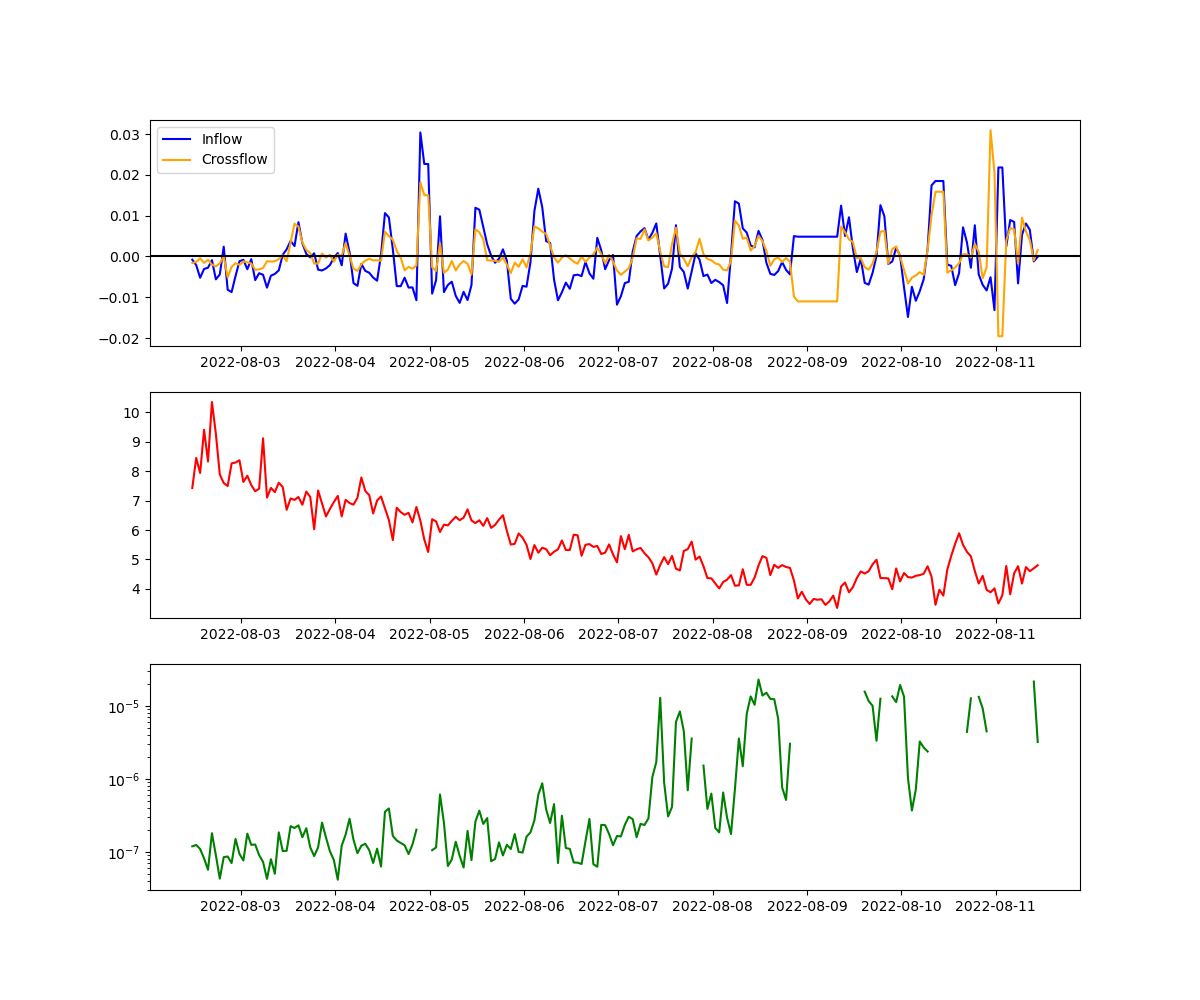

In [25]:
plt.figure(figsize = (12,10))
plt.subplot(311)
plt.plot(Prim.time, Prim, '-b', label = 'Inflow')
plt.plot(Sec.time, Sec, '-',color='orange', label = 'Crossflow')
plt.axhline(y=0,c='black')
plt.legend()
plt.subplot(312)
plt.plot(eps1.time_start, eps1.Tavg, '-r', label = 'Wave Height')
plt.subplot(313)
plt.plot(goodEps.time_start, goodEps, '-g')
plt.yscale('log')

In [ ]:
# NBDC data
ndbc_46042 = xr.open_dataset('NDBC/ndbc_46042_2022.nc')
ndbc_46239 = xr.open_dataset('NDBC/ndbc_46239_2022.nc')
tStart = '2022-08-02T11:40:00.000000000'
tEnd = '2022-08-11T11:00:00.000000000'
tStart2 = '2022-08-15T08:40:00.000000000'
tEnd2 = '2022-08-30T10:40:00.000000000'

rSamp = '60Min'

dep1_46239 = ndbc_46239.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')
dep1_46042 = ndbc_46042.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')

dep2_46239 = ndbc_46239.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')
dep1_46042 = ndbc_46042.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')
def wave_plot(WAVEdata, ST46042, ST46239, tStart, tEnd, rSamp, T_Range = None, supTitle = None, saveFig = None): 

    ADVds = WAVEdata.copy(deep=True)
    
    #Import offshore waveheight, average and dominant wave period, and mean wave direction
    st46239 = ST46239.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')
    st46042 = ST46042.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean().dropna(dim='time', how='all')
    ADVds = ADVds.sel(time_start = slice(tStart, tEnd)).resample(time = rSamp)

    fig, axs = plt.subplots(4,1,constrained_layout = True, figsize = (10,10))
    
    if supTitle:
        fig.suptitle(str(supTitle), x = .465, size = 20)
    
    fig.set_constrained_layout_pads(hspace=0.1, wspace=0.1)
    
    axs[0].set_title('Significant Wave Height')
    axs[0].plot(st46042.time, st46042.WVHT, '-k', lw = 2, label = 'Station 46042')
    axs[0].plot(st46239.time, st46239.WVHT, '-r', lw = 2, label = 'Station 46239')
    axs[0].plot(ADVds.time_start, ADVds.Hs, '-g', lw = 2, label = 'SWC Mooring')
    axs[0].set_ylabel('Height (m)', size = 12)
    axs[0].tick_params(axis = 'x', labelrotation = 15)
    axs[0].margins(x=.01)
    axs[0].legend(loc='upper right')
    
    axs[1].set_title('Standard Deviation in Depth from SWC ADV')
    axs[1].plot(waveData.time, waveData.Hstd, '-g', label = 'SWC Mooring (ADV)')
    axs[1].set_ylabel('ADV depth std.(m)')
    axs[1].tick_params(axis = 'x', labelrotation = 15)
    axs[1].margins(x=.01)
    axs[1].legend(loc='upper right')
    
    axs[2].set_title('Mean Wave Direction from Offshore Buoys')
    axs[2].plot(MWD_46042.time, MWD_46042, '-k', lw = 2, label = 'Station 46042')
    axs[2].plot(MWD_46239.time, MWD_46239, '-r', lw = 2, label = 'Station 46239')
    axs[2].set_ylabel('Direction (Degrees)', size = 12)
    axs[2].tick_params(axis = 'x', labelrotation = 15)
    axs[2].margins(x=.01)

    #bounds = np.array([1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 7.5e-5, 1e-4])
    #norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    norm = matplotlib.colors.LogNorm(vmin = 5e-6, vmax = 1e-4)
    axs[3].set_title('Average Wave Period from ADV Pressure Spectra and Offshore Buoys')
    wavePlot = axs[3].pcolormesh(waveData.time, waveData.period, waveData.waveSpectra.T, 
                                 norm = norm, cmap = 'viridis', shading = 'auto')
    axs[3].plot(APD_46042.time, APD_46042, '-k', lw = 2, label = 'Station 46042')
    axs[3].plot(APD_46239.time, APD_46239, '-r', lw = 2, label = 'Station 46239')
    if T_Range:
        axs[3].set_ylim(T_Range[0],T_Range[1])
    axs[3].set_ylabel('Period (s)', size = 12)
    axs[3].set_xlabel('Date', size = 12)
    axs[3].tick_params(axis = 'x', labelrotation = 15)
    cb = fig.colorbar(wavePlot, ax=axs[3], orientation='vertical').set_label(
        label=r"$\frac{m^{2}}{s^{2}}$",size=14,rotation = -90, va = 'bottom')
    
    if saveFig:
        plt.savefig(str(saveFig))

0.5810461508603 0.8217233469113195 6.330719639894992 7.5


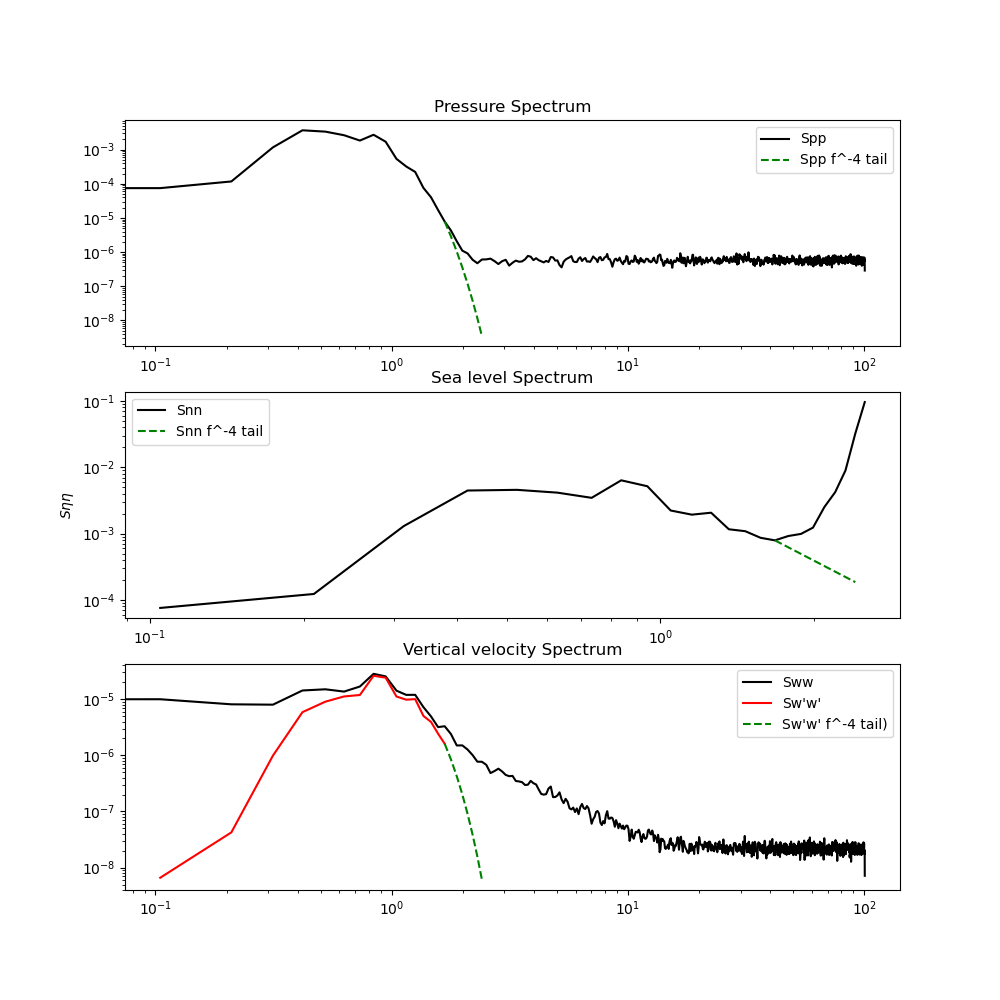

In [71]:
ds = adv1Spectra
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title('Pressure Spectrum')
plt.loglog(ds.omega, ds.Spp, '-k', label = 'Spp')
plt.loglog(omega[fcIDX:wavetailCutoff+1], SpModel[fcIDX:wavetailCutoff+1], '--g', label = 'Spp f^-4 tail')
plt.legend()
plt.subplot(312)
plt.title('Sea level Spectrum')
plt.loglog(omega, Sn, '-k', label = "Snn")
plt.loglog(omega[fcIDX:wavetailCutoff+1], SnModel[fcIDX:wavetailCutoff+1], '--g', label = "Snn f^-4 tail")
plt.ylabel(r'$S\eta\eta$')
plt.legend()
plt.subplot(313)
plt.title('Vertical velocity Spectrum')
plt.loglog(omega, SwOmega, '-k', label = 'Sww')
plt.loglog(omega[:fcIDX+1], SwPrimeModel[:fcIDX+1], '-r', label = "Sw'w'")
plt.loglog(omega[fcIDX:wavetailCutoff+1], SwPrimeModel[fcIDX:wavetailCutoff+1], '--g', label = "Sw'w' f^-4 tail)")
plt.legend()

print(Hrms, Hs, Tavg, Tpeak)